In [16]:
import pandas as pd
from datetime import datetime

# Merge the datasets
#data = pd.read_csv(r'C:\Users\DimitrideBoer\OneDrive - Emixa\Documents\XRAYxEmixaHackathon\data\RecommenderSystem_withoutcompany300520241508.csv')
data = pd.read_csv(r'C:\Users\DimitrideBoer\OneDrive - Emixa\Documents\XRAYxEmixaHackathon\data\car 1.csv')
data['createdon'] = pd.to_datetime(data['createdon'])

C:\Users\DimitrideBoer\AppData\Local\Temp\ipykernel_18596\2570252936.py:6: DtypeWarning: Columns (3,6,18,21,28,31,32,42,51,53,61,64,66,70,75,78,80,82,83,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'C:\Users\DimitrideBoer\OneDrive - Emixa\Documents\XRAYxEmixaHackathon\data\car 1.csv')


In [17]:
data = data[data['createdon'] >= (datetime.now() - pd.DateOffset(years=3))]

In [18]:
# Function to convert columns
def convert_columns(df):
    for column in df.columns:
        if column.startswith('is') or column.startswith('has'):
            df[column] = df[column].astype(bool)
        else:
            if pd.api.types.is_numeric_dtype(df[column]):
                df[column] = pd.to_numeric(df[column], errors='coerce')
            else:
                df[column] = df[column].astype(str)
    return df

In [19]:
data = convert_columns(data)

In [20]:
[i for i in data.columns if 'brand' in i]

['migration_brand', 'brandname']

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [21]:
data = data[['brandname',
    'fueltype', 'hascosts', 'cardistancevalue', 'cartypename', 'catalogvalue', 'modelnameshort',
    'orderid', 'vatmargin', 'enginehorsepower', 'bpmvalue', 'duedateapk', 'bodytype',
    'xrayvalue', 'remainingbpmvalue', 'equipmentvalue', 'vehicletype', 'costsvalue', 'transmissiontype',
    'isimportcar', 'catalogincludingvalue', 'hasdamage', 'minbid', 'batterycapacity', 'hascostsmanual',
    'taxliabilitypercentage']]

In [22]:
# Automatically identify column types
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# numerical_features = [ 'hasairco',
#  'hascosts',
#  'cardistancevalue']
numerical_features

['cardistancevalue',
 'catalogvalue',
 'orderid',
 'enginehorsepower',
 'bpmvalue',
 'xrayvalue',
 'remainingbpmvalue',
 'equipmentvalue',
 'costsvalue',
 'catalogincludingvalue',
 'minbid']

In [23]:
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
# categorical_features = ['tirerating',
#  'electricalrating',
#  'fueltype',
#  'interiorcolor']

In [24]:
boolean_features = data.select_dtypes(include=['bool']).columns.tolist()

In [48]:
# Convert specific columns to string dtype
#data[['tirerating', 'electricalrating', 'fueltype', 'interiorcolor']] = data[['tirerating', 'electricalrating', 'fueltype', 'interiorcolor']].astype(str)

In [27]:
# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='most frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing for boolean features
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # No need for additional transformation; booleans are already binary
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features + boolean_features)
    ]
)

x = preprocessor.fit_transform(data)

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

c:\Users\DimitrideBoer\OneDrive - Emixa\Documents\XRAYxEmixaHackathon\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


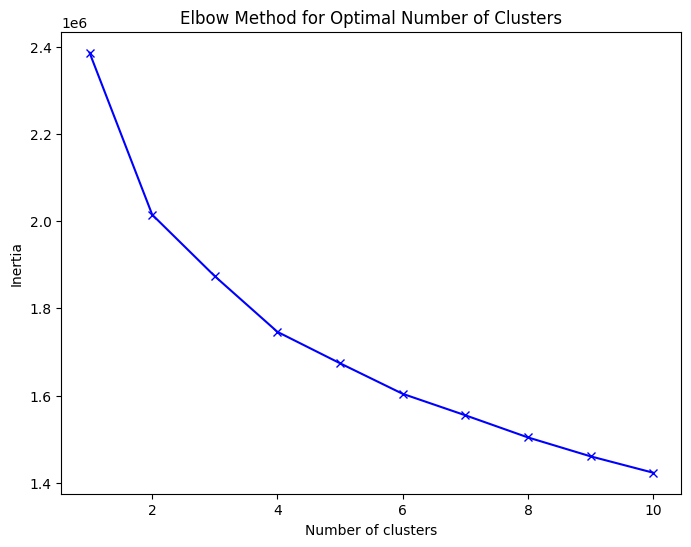

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [30]:
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KMeans(n_clusters=5, random_state=42))])

In [31]:
data['cluster'] = model.fit_predict(data)

c:\Users\DimitrideBoer\OneDrive - Emixa\Documents\XRAYxEmixaHackathon\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering

Save model to ONNX

In [5]:
#import onnx

In [6]:
#from onnx.defs import onnx_opset_version

In [7]:
#onnx_opset_version()

In [34]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType #, BooleanTensorType

# Define the initial type for the input
initial_type = [('float_input', FloatTensorType([None, data[numerical_features].shape[1]]))]

initial_type = [('hasairco', FloatTensorType([1, 1])),
                ('hascosts', FloatTensorType([1, 1])),
                ('cardistancevalue', FloatTensorType([1, 1])),
                ('tirerating', StringTensorType([1, 1])),
                ('electricalrating', StringTensorType([1, 1])),
                ('fueltype', StringTensorType([1, 1])),
                ('interiorcolor', StringTensorType([1, 1]))
                ]

initial_type = [('cardistancevalue', FloatTensorType([1, 1])),
                ('catalogvalue', FloatTensorType([1, 1])),
                ('orderid', FloatTensorType([1, 1])),
                ('enginehorsepower', FloatTensorType([1, 1])),
                ('bpmvalue', FloatTensorType([1, 1])),
                ('xrayvalue', FloatTensorType([1, 1])),
                ('remainingbpmvalue', FloatTensorType([1, 1])),
                ('equipmentvalue', FloatTensorType([1, 1])),
                ('costsvalue', FloatTensorType([1, 1])),
                ('catalogincludingvalue', FloatTensorType([1, 1])),
                ('minbid', FloatTensorType([1, 1])),
                ('brandname', StringTensorType([1,1])),
                ('fueltype', StringTensorType([1, 1])),
                ('cartypename', StringTensorType([1, 1])),
                ('modelnameshort', StringTensorType([1, 1])),
                ('vatmargin', StringTensorType([1, 1])),
                ('modelnameshort', StringTensorType([1, 1])),
                ('duedateapk', StringTensorType([1, 1])),
                ('bodytype', StringTensorType([1, 1])),
                ('vehicletype', StringTensorType([1, 1])),
                ('transmissiontype', StringTensorType([1, 1])),
                ('batterycapacity', StringTensorType([1, 1])),
                ('taxliabilitypercentage', StringTensorType([1, 1])),
                ('hascosts', StringTensorType([1, 1])),
                ('isimportcar', StringTensorType([1, 1])),
                ('hasdamage', StringTensorType([1, 1])),
                ('hascostsmanual', StringTensorType([1, 1]))
                ]


# Convert the KMeans model to ONNX format
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model to a file
with open("kmeans_model9.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [35]:
import numpy as np

In [36]:
np.unique(data['cluster'])

array([0, 1, 2, 3, 4])

In [37]:
bidData = pd.read_csv(r'C:\Users\DimitrideBoer\OneDrive - Emixa\Documents\XRAYxEmixaHackathon\data\RecommenderSystemNonPivotedWithOrderidLast3Year.csv')

In [38]:
len(data)

122775

In [39]:
len(bidData)

1071636

In [40]:
bidData.columns

Index(['orderid', 'fueltype', 'hascosts', 'cardistancevalue', 'cartypename',
       'catalogvalue', 'modelnameshort', 'vatmargin', 'enginehorsepower',
       'bpmvalue', 'duedateapk', 'bodytype', 'xrayvalue', 'remainingbpmvalue',
       'equipmentvalue', 'vehicletype', 'costsvalue', 'transmissiontype',
       'isimportcar', 'catalogincludingvalue', 'hasdamage', 'minbid',
       'batterycapacity', 'hascostsmanual', 'taxliabilitypercentage',
       'companyname'],
      dtype='object')

In [41]:
customerCluster = bidData.merge(data[['orderid', 'cluster']], how='left', on='orderid')[['companyname', 'cluster']]

In [42]:
np.unique(customerCluster['cluster'])

array([ 0.,  1.,  2.,  3.,  4., nan])

In [43]:
cluster_counts = customerCluster.groupby(['companyname', 'cluster']).size().reset_index(name='count')

In [44]:
cluster_counts

,companyname,cluster,count
0,ASV Automobielbedrijven BV,4.0,1
1,ASV MB Eindhoven BV,0.0,1
2,ASV MB Eindhoven BV,2.0,1
3,Ames Autobedrijf BV - Zwijndrecht,4.0,1
4,Auto Avantgarde,0.0,15
...,...,...,...
417,van der Poel Occasions,4.0,147
418,vd Boon Auto's,0.0,2
419,vd Boon Auto's,1.0,609
420,vd Boon Auto's,2.0,14


In [45]:
# Grouping by 'companyname' and 'cluster' and counting occurrences
cluster_counts2 = customerCluster.groupby(['companyname', 'cluster']).size().unstack(fill_value=0)

# Display the result
print(cluster_counts2)

cluster                            0.0   1.0   2.0  3.0   4.0
companyname                                                  
ASV Automobielbedrijven BV           0     0     0    0     1
ASV MB Eindhoven BV                  1     0     1    0     0
Ames Autobedrijf BV - Zwijndrecht    0     0     0    0     1
Auto Avantgarde                     15    63     0    0     1
Auto Druten B.V.                    84    76  1059    0  1483
...                                ...   ...   ...  ...   ...
van Dam Auto's                     375   953    26    0   499
van Dijk Automotive B.V.           265  1252   287    0  1712
van den Hurk Auto's                803   686    34    0   389
van der Poel Occasions              49   490    65    0   147
vd Boon Auto's                       2   609    14    0   315

[127 rows x 5 columns]


In [46]:
threshold_percentage = 0.4


# Calculate the maximum value for each company
max_values = cluster_counts2.max(axis=1)

# Create a boolean mask to filter out clusters below the threshold
mask = cluster_counts2.apply(lambda x: x >= threshold_percentage * max_values[x.name], axis=1)

# Apply the mask to the DataFrame
filtered_df = cluster_counts2.where(mask, other=0)

# Create a list of clusters for each company
cluster_list_df = filtered_df.apply(lambda row: [col for col in filtered_df.columns if row[col] > 0], axis=1).reset_index()

# Rename the columns
cluster_list_df.columns = ['companyname', 'significant_clusters']

# Display the result
print(cluster_list_df)
cluster_list_df.to_csv('companyClusterAllocation2.csv')

                           companyname significant_clusters
0           ASV Automobielbedrijven BV                [4.0]
1                  ASV MB Eindhoven BV           [0.0, 2.0]
2    Ames Autobedrijf BV - Zwijndrecht                [4.0]
3                      Auto Avantgarde                [1.0]
4                     Auto Druten B.V.           [2.0, 4.0]
..                                 ...                  ...
122                     van Dam Auto's           [1.0, 4.0]
123           van Dijk Automotive B.V.           [1.0, 4.0]
124                van den Hurk Auto's      [0.0, 1.0, 4.0]
125             van der Poel Occasions                [1.0]
126                     vd Boon Auto's           [1.0, 4.0]

[127 rows x 2 columns]


Building the Recommender System

Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Implement the recommender system on the training set
# (same steps as above, but using train_data instead of the entire dataset)

# Generate recommendations for users in the test set and evaluate
# (Assume we have a function `evaluate_recommendations` to calculate the metrics)

# Evaluate the recommender system
def evaluate_recommendations(test_data):
    y_true = []
    y_pred = []
    
    for _, row in test_data.iterrows():
        user_id = row['xbs$companyid']
        true_car_id = row['orderId']
        
        recommended_cars = recommend_cars(user_id)
        recommended_car_ids = recommended_cars['car_id'].values
        
        y_true.append(true_car_id)
        y_pred.append(true_car_id in recommended_car_ids)
    
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    return precision, recall, f1

precision, recall, f1 = evaluate_recommendations(test_data)
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')
